In [ ]:
import numpy as np
import math
import scipy.sparse as sp
import scipy.sparse.linalg as la

In [ ]:
def solver(limit, L, number):
        x = np.linspace(-limit, limit, L)
        y = np.linspace(-limit, limit, L)

        #grid spacing
        dx = x[1]-x[0]
        dy = y[1]-y[0]

        mesh = np.meshgrid(x, y)
        block = sp.diags([-1,4,-1], [-1,0,1],(L,L)) #main tri-diagonal
        dia = sp.block_diag((block,)*L)  #repeat it num times to create the main block-diagonal
        sup = sp.diags([-1],[L],(L**2,L**2)) # super-diagonal fringe
        sub = sp.diags([-1],[-L],(L**2,L**2)) #sub-diagonal fringe

        T = (dia + sup + sub) / (2*dx*dy)
    
        def solve(potential):
            V = sp.lil_matrix((L**2, L**2))
            V.setdiag(potential.flatten())
    
            H = T + V
            E= la.eigs(H, k=3, which='SM', return_eigenvectors=False)
    
            return E
    
        def V_SHO(mesh,kx,ky,cx=0,cy=0):
            (x,y) = mesh
            V = 0.5 * (kx*(x-cx)**2 + ky*(y-cy)**2)
            return V
        
        np.random.seed(99)
        kx = np.random.rand(number) * 0.64
        ky = np.random.rand(number) * 0.64
        cx = (np.random.rand(number) - 0.5) * 64
        cy = (np.random.rand(number) - 0.5) * 64
        
        image_list=[]
        energy_list=[]
        
        for i in range(number):
            V_image=V_SHO(mesh, kx[i], ky[i], cx[i], cy[i])
            E0= solve(V_SHO(mesh, kx[i], ky[i], cx[i], cy[i]))
            image_list.append(V_image)
            energy_list.append(E0)
        
        def V_INFW(a, b, lx, ly, ca, cb):
        
          V = np.zeros((L,L)) 
          for i in range(L):
              for j in range(L):
                  if (0.5*(2*ca-lx)<a[i] and a[i]<0.5*(2*ca+lx))and(0.5*(2*cb-ly)<b[j] and b[j]<0.5*(2*cb+ly)):
                      V[i][j]=0
                  else:
                      V[i][j]=20
          return V
    
        np.random.seed(123)
        Ly=[]
        Lx=[]
        cx=[]
        cy=[]
        E = np.random.rand(number) * 0.4
        S = (np.random.rand(number) * 11) + 4
        for i in range(number):
          a = (2*E[i]/math.pi**2)-(1/S[i]**2)
          if a>0:
            Ly.append(1/math.sqrt(a))
            Lx.append(S[i])
        cx = (np.random.rand(len(Lx)) - 0.5) * 16
        cy = (np.random.rand(len(Lx)) - 0.5) * 16

        for k in range(len(Lx)):
          V_image_1 = V_INFW(x,y,Lx[k],Ly[k],cx[k],cy[k])
          E1 = solve(V_INFW(x,y,Lx[k],Ly[k],cx[k],cy[k]))
          image_list.append(V_image_1)
          energy_list.append(E1)

        return image_list, energy_list

In [ ]:
L=64
data0, labels0 = solver(limit=20, L=L, number=8000)

In [ ]:
p = int(0.8*np.shape(data0)[0])
q = int(0.2*np.shape(data0)[0])+1
train_data_1 = data0[:p]
test_data_1 = data0[p:]
train_labels_1 = labels0[:p]
test_labels_1 = labels0[p:]
np.shape(test_data_1)

(2865, 64, 64)

In [ ]:
train_data_2=np.array(train_data_1)
test_data_2=np.array(test_data_1)
train_labels_2=np.array(train_labels_1)
test_labels_2=np.array(test_labels_1)
conv_training_data = train_data_2.reshape(p, 64, 64, 1)
conv_test_data = test_data_2.reshape(q, 64, 64, 1)
np.shape(conv_training_data)

(11459, 64, 64, 1)

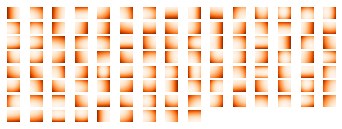

In [ ]:
import matplotlib.pyplot as plt
for i in range(int(0.01*np.shape(conv_training_data)[0])):
    ax = plt.subplot(15, 15, i+1)
    ax.axis('off')
    plt.imshow(train_data[i], cmap='Oranges')

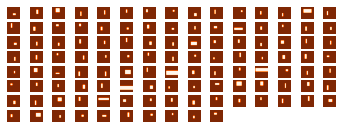

In [ ]:
for i in range(int(0.99*np.shape(conv_training_data)[0]),np.shape(conv_training_data)[0]):
    ax = plt.subplot(15, 15, i-int(0.99*np.shape(conv_training_data)[0])+1)
    ax.axis('off')
    plt.imshow(train_data[i], cmap='Oranges')

In [ ]:
def plot_training_history(history, model, eval_images=False):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()
    
    if eval_images:
        loss, accuracy  = model.evaluate(conv_test_data, test_labels_2, verbose=False)
    else:
        loss, accuracy  = model.evaluate(test_data_2, test_labels_2, verbose=False)
        
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

In [ ]:
#Convolutional Neural Network
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), activation='relu', padding='same', input_shape=(64,64,1)))


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',))


model.add(Flatten())
model.add(Dense(3, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Train on 10313 samples, validate on 1146 samples
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


10313/10313 [==============================] - 128s 12ms/step - loss: 211.5701 - accuracy: 0.8530 - val_loss: 1.6171 - val_accuracy: 0.7757
Epoch 2/20
10313/10313 [==============================] - 132s 13ms/step - loss: 47.7947 - accuracy: 0.8837 - val_loss: 0.1978 - val_accuracy: 0.5332
Epoch 3/20
10313/10313 [==============================] - 128s 12ms/step - loss: 39.2697 - accuracy: 0.8564 - val_loss: 0.7328 - val_accuracy: 0.5602
Epoch 4/20
10313/10313 [==============================] - 128s 12ms/step - loss: 42.4040 - accuracy: 0.8232 - val_loss: 0.3081 - val_accuracy: 0.5899
Epoch 5/20
10313/10313 [==============================] - 128s 12ms/step - loss: 68.1295 - accuracy: 0.7998 - val_loss: 1.2251 - val_accuracy: 0.6126
Epoch 6/20
10313/10313 [==============================] - 128s 12ms/step - loss: 41.1606 - accuracy: 0.8368 - val_loss: 1.5061 - val_accuracy: 0.5253
Epoch 7/20
10313/10313 [==============================] - 132s 13ms/step - loss: 37.6030 - accuracy: 0.8441 - 

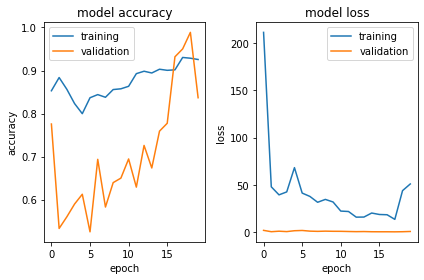

Test loss: 0.395
Test accuracy: 0.824


In [ ]:
history = model.fit(conv_training_data, train_labels_2, batch_size=16, epochs=20, verbose=True, validation_split=.1)

plot_training_history(history, model, eval_images=True)

In [ ]:
predictions = model.predict(conv_test_data)
prediction_1 = np.array(predictions).flatten()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6104: ComplexWarning: Casting complex values to real discards the imaginary part
  coords = np.column_stack((X, Y)).astype(float, copy=False)


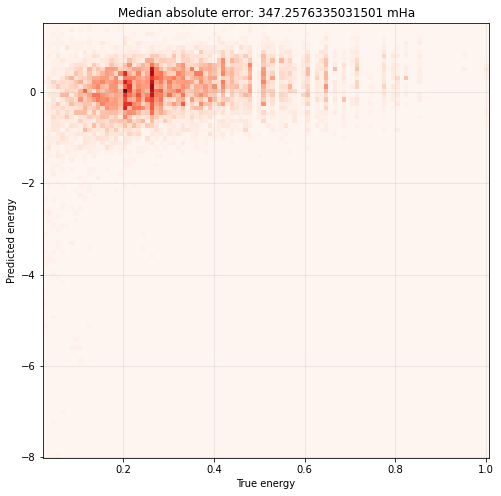

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
counts, xedges, yedges = np.histogram2d(test_labels_2.flatten(), prediction_1.flatten(), bins=100)

ax.pcolormesh(xedges, yedges, counts.T, cmap='Reds')

ax.set_xlabel("True energy")
ax.set_ylabel("Predicted energy")
ax.grid(alpha=0.3)
ax.set_title("Median absolute error: {0} mHa".format(np.median(np.abs(prediction_1.flatten() - test_labels_2.flatten()))*1000))
fig.show()